# Getting Started:
## A simple driving model training and evaluation pipeline using the Drive360 dataset and PyTorch.

## Loading data from Drive360 dataset.

The **dataset.py** file contains the 3 classes necessary for creating a Drive360Loader. Using the **config.json** file to specify the location of the csv and data directory, we can generate phase (train, validation, test) specific data loaders that can output samples from each set. Adjust the **dataset.py** to your preferred training framework.

In [1]:
import torch
import json
from datasetfull import Drive360Loader

# load the config.json file that specifies data 
# location parameters and other hyperparameters 
# required.
config = json.load(open('./config_hybrid_full.json'))

# create a train, validation and test data loader
train_loader = Drive360Loader(config, 'train')
validation_loader = Drive360Loader(config, 'validation')
test_loader = Drive360Loader(config, 'test')

# print the data (keys) available for use. See full 
# description of each data type in the documents.
print('Loaded train loader with the following data available as a dict.')
print(train_loader.drive360.dataframe.keys())

total_batch = len(train_loader)
print("Ready to train on {}".format(torch.cuda.current_device()))

Phase: train # of data: 39350
Phase: validation # of data: 10291
Phase: test # of data: 27920
Loaded train loader with the following data available as a dict.
Index(['cameraRight', 'cameraFront', 'cameraRear', 'cameraLeft', 'here',
       'tomtom', 'gpsLatitude', 'gpsLongitude', 'gpsAltitude', 'gpsPrecision',
       'hereMmLatitude', 'hereMmLongitude', 'hereSpeedLimit',
       'hereSpeedLimit_2', 'hereFreeFlowSpeed', 'hereSignal', 'hereYield',
       'herePedestrian', 'hereIntersection', 'hereMmIntersection',
       'hereSegmentExitHeading', 'hereSegmentEntryHeading',
       'hereSegmentOthersHeading', 'hereCurvature', 'hereCurrentHeading',
       'here1mHeading', 'here5mHeading', 'here10mHeading', 'here20mHeading',
       'here50mHeading', 'hereTurnNumber', 'canSteering', 'canSpeed',
       'chapter'],
      dtype='object')
Ready to train on 0


In [2]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete

## Training a basic driving model

Create your driving model. This is specific to your learning framework. 

Below we give a very basic dummy model that uses the front facing camera and a resnet34 + LSTM architecture to predict canSteering and canSpeed. 

In [3]:
from torchvision import models
import torch.nn as nn
    
class SomeDrivingModelResnet50(nn.Module):
    def __init__(self):
        super(SomeDrivingModelResnet50, self).__init__()
        # For number inputs
        self.number_labels = ['hereSpeedLimit',
                                'hereFreeFlowSpeed', 'hereSignal', 'hereYield',
                               'herePedestrian', 'hereIntersection', 'hereMmIntersection',
                               'hereSegmentExitHeading', 'hereSegmentEntryHeading',
                               'hereCurvature', 
                               'here1mHeading', 'here5mHeading', 'here10mHeading', 'here20mHeading',
                               'here50mHeading']
        final_concat_size = len(self.number_labels)
        
        # CNN Front
        cnn_front = models.resnet50(pretrained=True)
        self.front_features = nn.Sequential(*list(cnn_front.children())[:-1])
        self.front_intermediate = nn.Sequential(
            nn.Linear(cnn_front.fc.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),          
            nn.ReLU())
        final_concat_size += 128

        # Main LSTM
        self.front_lstm = nn.LSTM(input_size=128,
            hidden_size=64,
            num_layers=3,
            batch_first=False)
        final_concat_size += 64
        
        # CNN Tomtom
#        cnn_tomtom = models.resnet50(pretrained=True)
#        self.front_features = nn.Sequential(*list(cnn_tomtom.children())[:-1])
#        self.front_intermediate = nn.Sequential(nn.Linear(
#                          cnn_tomtom.fc.in_features, 128),
#                          nn.ReLU())
#        final_concat_size += 128
        
        # CNN HERE
#        cnn_here = models.resnet50(pretrained=True)
#        self.front_features = nn.Sequential(*list(cnn_here.children())[:-1])
#        self.front_intermediate = nn.Sequential(nn.Linear(
#                          cnn_here.fc.in_features, 128),
#                          nn.ReLU())
#        final_concat_size += 128
        
        # Angle Regressor
        self.control_angle = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # Speed Regressor
        self.control_speed = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, data):
        module_outputs = []
        lstm_i = []
        
        # Number parameters
        for numbers in self.number_labels:
            module_outputs.append(data[numbers].float().cuda())
            
        #Tomtom maps
        #module_outputs.append(data['tomtom'].cuda())
        
        # Loop through temporal sequence of
        # front facing camera images and pass 
        # through the cnn.
        for k, v in data['cameraFront'].items():
            v = v.cuda()
            x = self.front_features(v)
            x = x.view(x.size(0), -1)
            x = self.front_intermediate(x)
            lstm_i.append(x)
            # feed the current front facing camera
            # output directly into the 
            # regression networks.
            if k == 0:
                module_outputs.append(x)

        # Feed temporal outputs of CNN into LSTM
        i_lstm, _ = self.front_lstm(torch.stack(lstm_i))
        module_outputs.append(i_lstm[-1])
        
        # Concatenate current image CNN output 
        # and LSTM output.
        x_cat = torch.cat(module_outputs, dim=-1)
        
        # Feed concatenated outputs into the 
        # regession networks.
        prediction = {'canSteering': torch.squeeze(self.control_angle(x_cat)),
                      'canSpeed': torch.squeeze(self.control_speed(x_cat))}
        return prediction

A basic training procedure that iterates over the train_loader and feeds each sample into our dummy model, subsequently calculates loss. We kill after 20 batches just

In [4]:
def save_model(model, optimizer, epoch, loss, path):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                }, path)
    
def resume_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    model.cuda()
    #optimizer.cuda()
    
    return epoch, loss

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from copy import deepcopy
import math

def train_model(model, optimizer, criterion_speed, criterion_steering, epochs, scheduler, name, if_test, resume_path=None):
    hist_train_loss_speed = []
    hist_train_loss_steering = []
    hist_valid_loss_speed = []
    hist_valid_loss_steering = []
    
    model.cuda()
    best_model = None
    best_valid = math.inf
    
    if resume_path:
        epoch, _ = resume_model(model, optimizer, resume_path)
    else:
        epoch = 0
    
    while epoch < epochs:
        start = time.time()
        printProgressBar(0, total_batch, prefix = 'Progress:', suffix = 'Complete', length = 50)
        model.train()
        progress_counter = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad()
            prediction = model(data)

            steering_loss = criterion_steering(prediction['canSteering'].cuda(), target['canSteering'].cuda())
            speed_loss = criterion_speed(prediction['canSpeed'].cuda(), target['canSpeed'].cuda())
            loss = steering_loss + speed_loss
            hist_train_loss_speed.append(speed_loss.cpu().detach().numpy())
            hist_train_loss_steering.append(steering_loss.cpu().detach().numpy())
            
            loss.backward()
            optimizer.step()
            
            if scheduler:
                scheduler.step()
                
            progress_counter += 1
            if progress_counter >= 10:
                printProgressBar(batch_idx + 1, total_batch, prefix = 'Progress:', suffix = 'Complete', length = 50)
                progress_counter = 0
        printProgressBar(total_batch, total_batch, prefix = 'Progress:', suffix = 'Complete', length = 50)
        print()
        
        end = time.time() 
        print("Training minutes elapsed epoch{}: {}, {} left".format(epoch, round((end - start) / 60, 2), round((end - start) * (epochs - epoch - 1) / 60, 2)))

        model.eval()

        speed_sum = 0
        steering_sum = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(validation_loader):
                optimizer.zero_grad()
                prediction = model(data)
                speed_dif = prediction['canSpeed'].cpu() - target['canSpeed']
                steering_dif = prediction['canSteering'].cpu() - target['canSteering']
                speed_sum += (np.square(speed_dif)).mean()
                steering_sum += (np.square(steering_dif)).mean()
        hist_valid_loss_speed.append(speed_sum)
        hist_valid_loss_steering.append(steering_sum)
        print("Steering Error: {}\nSpeed Error: {}".format(float(steering_sum), float(speed_sum)))
        
        # Early Stopping
        if steering_sum < best_valid:
            best_model = deepcopy(model)
            best_valid = steering_sum
            Print("Find a new best model!")
        
        epoch += 1
    
    plt.plot(hist_train_loss_speed)
    plt.title("Speed Loss")
    now = datetime.now()
    plt.plot(hist_train_loss_speed)
    plt.title("Speed Loss")
    if not if_test:
        plt.savefig("./saved_figures/{}-{}-{}-speed.png".format(epochs, name, now.strftime("%m-%d-%Y-%H-%M-%S")))
    plt.show()
    plt.plot(hist_train_loss_steering)
    plt.title("Steering Loss")
    if not if_test:
        plt.savefig("./saved_figures/{}-{}-{}-angle.png".format(epochs, name, now.strftime("%m-%d-%Y-%H-%M-%S")))
    plt.show()
    if not if_test:
        save_model(model, optimizer, epoch, loss, 
                   "./saved_models/{}-{}-{}.pt".format(epochs, name, now.strftime("%m-%d-%Y-%H-%M-%S")))
        save_model(model, optimizer, epoch, loss, 
                   "./best_models/{}-{}-{}.pt".format(epochs, name, now.strftime("%m-%d-%Y-%H-%M-%S")))
    plt.plot(hist_valid_loss_speed)
    plt.title("Validating Speed Loss")
    plt.show()
    plt.plot(hist_valid_loss_steering)
    plt.title("Validating Steering Loss")
    plt.show()
    
    model = best_model

In [6]:
normalize_targets = config['target']['normalize']
target_mean = config['target']['mean']
target_std = config['target']['std']

def add_results(results, output):
    steering = np.squeeze(output['canSteering'].cpu().data.numpy())
    speed = np.squeeze(output['canSpeed'].cpu().data.numpy())
    if normalize_targets:
        steering = (steering*target_std['canSteering'])+target_mean['canSteering']
        speed = (speed*target_std['canSpeed'])+target_mean['canSpeed']
    if np.isscalar(steering):
        steering = [steering]
    if np.isscalar(speed):
        speed = [speed]
    results['canSteering'].extend(steering)
    results['canSpeed'].extend(speed)

test_chapter_length = [2997 for i in range(98)]
test_chapter_length[14] = 2996
test_chapter_length[36] = 2996
test_chapter_length[38] = 2996
test_chapter_length[63] = 1277
test_chapter_length[64] = 2861
test_chapter_length[66] = 2014
test_chapter_length[70] = 2996
test_chapter_length[72] = 2690
test_chapter_length[81] = 2106
test_chapter_length[85] = 2996
test_chapter_length[92] = 2996

for i in range(len(test_chapter_length)):
    test_chapter_length[i] -= 100
    
print("Number of test data: {}".format(sum(test_chapter_length)))

import pandas as pd

def create_submission(model_index, initial_offset, interval):
    now = datetime.now()
    file_name = "./submissions/{}-{}.csv".format(names[model_index], now.strftime("%m-%d-%Y-%H-%M-%S"))
    results = {'canSteering': [],
               'canSpeed': []}

    final_result = {'canSteering': np.zeros(279863, dtype="float64"),
                    'canSpeed': np.zeros(279863, dtype="float64")}
    final_result['canSteering'][:] = np.nan
    final_result['canSpeed'][:] = np.nan


    start = time.time()
    print("Start creating submission file {}, offset:{}, interval:{}".format(file_name, initial_offset, interval))
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            prediction = user_models[model_index](data)
            add_results(results, prediction)
    
    index = 0
    chapter_cap = 0
    r_index = 0
    for chapter_num in test_chapter_length:
        index = chapter_cap + initial_offset
        
        #Fill the leading indices
        final_result['canSteering'][chapter_cap] = results['canSteering'][r_index]
        final_result['canSpeed'][chapter_cap] = results['canSpeed'][r_index]
        
        chapter_cap += chapter_num
        while index < chapter_cap:
            final_result['canSteering'][index] = results['canSteering'][r_index]
            final_result['canSpeed'][index] = results['canSpeed'][r_index]
            
            index += interval
            r_index += 1
            
        #Fill the trailing indices
        #print(index, chapter_cap, r_index)
        final_result['canSteering'][chapter_cap - 1] = results['canSteering'][r_index - 1]
        final_result['canSpeed'][chapter_cap - 1] = results['canSpeed'][r_index - 1]

    df = pd.DataFrame.from_dict(final_result, dtype='float64')
    df.interpolate(method='linear', limit_direction='forward', inplace=True)
    df.to_csv(file_name, index=False)

    end = time.time() 
    print("Minutes elapsed: {}".format(round((end - start) / 60, 2)))

Number of test data: 279863


## Local evaluation of the model.

In [7]:
def cross_validation(user_models, optimizers, names, index, epochs=1, if_test=False, scheduler=None, resume_path=None):
    print(names[index] + ": ")
    train_model(user_models[index], optimizers[index], nn.SmoothL1Loss(), nn.SmoothL1Loss(), epochs, scheduler, names[index], if_test, resume_path)
    print("--------------------------------------------------------------")
    if not if_test:
        create_submission(index, config["initial_offset"], config["interval"])

In [8]:
import torch.optim as optim

user_models = [SomeDrivingModelResnet50(), SomeDrivingModelResnet50(), 
               SomeDrivingModelResnet50(), SomeDrivingModelResnet50()]
optimizers = [optim.AdamW(user_models[0].parameters(), lr=0.0001),
             optim.AdamW(user_models[1].parameters(), lr=0.001),
             optim.AdamW(user_models[2].parameters(), lr=0.0001),
             optim.AdamW(user_models[3].parameters(), lr=0.0001)]
names = ["FullResnet50NoLossModification-lr-0.0001", 
        "Resnet50Dropout-lr-0.001",
        "Resnet50Dropout-lr-0.0001",
        "Resnet50BatchNormDropout-lr-0.0001"]

FullResnet50NoLossModification-lr-0.0001: 
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch2: 1.71, 29.01 left
Steering Error: 26.063060760498047
Speed Error: 47.27777099609375
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch3: 1.73, 27.61 left
Steering Error: 25.053020477294922
Speed Error: 40.947994232177734
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch4: 1.7, 25.52 left
Steering Error: 24.20449447631836
Speed Error: 39.227684020996094
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch5: 1.71, 23.93 left
Steering Error: 23.49468231201172
Speed Error: 40.26276397705078
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch6: 1.72, 22.3 left
Steering Error: 23.399341583251953
Speed Error: 41

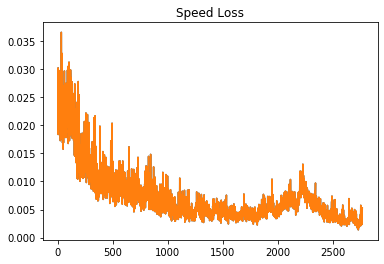

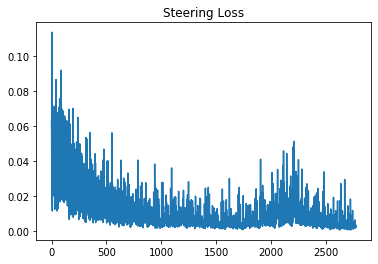

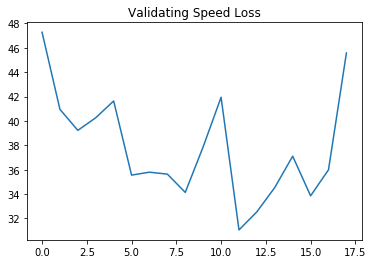

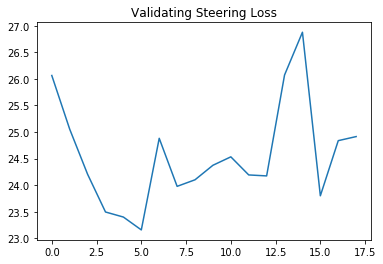

--------------------------------------------------------------
Start creating submission file ./submissions/FullResnet50NoLossModification-lr-0.0001-10-19-2019-20-57-18.csv, offset:9, interval:10


In [ ]:
cross_validation(user_models, optimizers, names, 0, 20, False, resume_path="./saved_models/2-FullResnet50NoLossModification-lr-0.0001-10-19-2019-20-10-23.pt")

#cross_validation(user_models, optimizers, names, 1, 10, True)

#cross_validation(user_models, optimizers, names, 2, 100)

#cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, names, 3)

In [ ]:
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizers[0], base_lr=0.000001, max_lr=0.001, cycle_momentum=False)
#cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 0, 
#                 "(Resnet50 Model, AdamW optimizer, SmoothL1Loss, Cyclic LR)")

## Creating a submission file.

We use pandas to create a submission file which is simply a 2-column csv with a canSteering and canSpeed prediction for each row in the **drive360_test.csv** a total of 305437 rows/predictions not including the header. See the **sample_submission.csv** file as an example.

IMPORTANT: for the test phase indices will start 10s (100 samples) into each chapter this is to allow challenge participants to experiment with different temporal settings of data input. If challenge participants have a greater temporal length than 10s for each training sample, then they must write a custom function here. Please check out the **dataset.py** file for additional explanation.

In [ ]:

    

#create_submission(1, config["initial_offset"], config["interval"])
#create_submission(2, config["initial_offset"], config["interval"])
#create_submission(3, config["initial_offset"], config["interval"])